In [1]:
!pip install --upgrade -q gspread

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd


# === 2. Cargar tu dataset ===
df = pd.read_csv("EURES_CAT_SENTIMENT.csv")

# Mostrar las primeras filas
df.head()

,id,timestamp,titulo,ocupacion,descripcion,provincia,tipo_contrato,descripcion_proc,sector,probs,sentimiento
0,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),corredor de seguros/corredora de seguros,tareas:prospección de nuevos asegurados.planif...,Asturias,Contrato,tarea prospección asegurado planificación gest...,Administración y Finanzas,{'Hostelería y Turismo': np.float64(0.04141047...,0
1,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,Conductor de vehículo de carga/conductora de v...,descripción: se necesita cubrir cuatro puestos...,Huesca,Contrato,descripción necesitar cubrir puesto empresa mo...,Logística y Transporte,{'Hostelería y Turismo': np.float64(0.03098547...,0
2,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,EDUCADORES SOCIALES,Trabajador social/trabajadora social,educador social para hogar en arinaga. fines d...,Las Palmas,Determinado,educador social hogar arinaga fin semana festi...,Educación y Formación,{'Hostelería y Turismo': np.float64(0.09141705...,0
3,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,PIZZERO (REF. 042025002051),Pizzero/pizzera,funciones: elaboración de pizzas requisitos: 2...,Islas Baleares,Determinado,función elaboración pizza requisito mes experi...,Hostelería y Turismo,{'Hostelería y Turismo': np.float64(0.32179939...,0
4,https://europa.eu/eures/portal/jv-se/jv-detail...,10/10/2025,INTÉRPRETES DE LA LENGUA DE SIGNOS,intérprete de lengua de signos,intérprete de lengua de signos para puestos en...,Santa Cruz de Tenerife,Determinado,intérprete lengua signo puesto ies manuel mart...,"Cultura, Arte y Ocio",{'Hostelería y Turismo': np.float64(0.08064752...,0


In [4]:
# Eliminar posibles valores nulos
df = df.dropna(subset=['descripcion_proc']).reset_index(drop=True)

# Lista de textos
documents = df['descripcion_proc'].tolist()
print(f"Total documentos: {len(documents)}")


Total documentos: 7260


In [103]:
# 1) Stopwords ES+EN (NLTK)
# !pip install -q nltk
# import nltk; nltk.download('stopwords')
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import CountVectorizer

stop_es = set(stopwords.words('spanish'))
stop_en = set(stopwords.words('english'))

extra_stops = {'oferta', 'número', 'experiencia', 'contrato', 'jornada',
               'trabajo', 'email', 'empleo', 'cod', 'horario', 'dni', 'nie',
               'inscrito', 'función', 'salario', 'requisito', 'persona',
               'referencia', 'currículo', 'laboral', 'labora', 'imprescindible',
               'trabajar', 'interesado', 'contacto', 'currículum', 'org', 'www',
               'contacto', 'dato', 'interesado', 'condición' 'amb', 'curriculum',
               'candatura', 'per', 'punt', 'puntlaboro', 'ofrecer', 'gva',
               'lang', 'emp', 'convenio', 'condición', 'indicar', 'asunto',
               'empleocastillayleon', 'comunidad', 'portal', 'app', 'jcyl',
               'teléfono', 'lunes', 'viernes', 'incorporar', 'semanal',
               'postular', 'llamar', 'conocimiento', 'incorporación',
               'especificar', 'residir', 'formación', 'mes', 'año',
               'valorar', 'oficinavirtual', 'necesitar', 'ubicado', 'mañana',
               'disponibilidad', 'adjuntar', 'turno', 'semana', 'pdf', 'etc',
               'similar'
}
my_stop_words = stop_es.union(stop_en).union(extra_stops)

# 2) Vectorizador afinado para español (Unicode + tildes/ñ), sin números
tf_vectorizer = CountVectorizer(
    stop_words=list(my_stop_words), # Convert the set to a list
    min_df=3,            # sube a 3–5 si hay mucho ruido
    max_df=0.1,         # descarta términos demasiado frecuentes
    lowercase=True,
    max_features=50000,
    token_pattern=r'(?u)\b[^\W\d_]{3,}\b',  # solo letras unicode (incluye áéíóúüñ)
    analyzer='word'
)

bag_of_words = tf_vectorizer.fit_transform(documents)
dictionary = tf_vectorizer.get_feature_names_out()
print("Tamaño del vocabulario:", len(dictionary))

# 3) Top términos para revisar y ampliar stopwords si hace falta
import numpy as np
s = np.asarray(bag_of_words.sum(axis=0)).ravel()
st = s.argsort()[::-1]
for i, idx in enumerate(st[:30]):
    print(dictionary[idx], int(s[idx]))

Tamaño del vocabulario: 4800
atención 944
cliente 914
mantenimiento 913
social 812
carnet 788
tarea 763
personal 742
vehículo 727
instalación 666
parcial 635
mínimo 617
certificado 606
solicitar 593
residencia 591
grado 586
cumplir 585
requerir 571
oportunidad 567
grupo 555
administrativo 536
responsable 531
posibilidad 501
superior 492
cubrir 492
inaem 490
industrial 489
candidato 484
proceso 481
actividad 472
murcia 469


In [104]:
# Número de tópicos (ajústalo luego)
topics = 5
alpha = 1
beta = 1

lda = LatentDirichletAllocation(
    n_components=topics,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
    max_iter=25,
    learning_method='online',
    evaluate_every=1,
    random_state=0,
    n_jobs=-1,
    verbose=1
)

lda.fit(bag_of_words)


iteration: 1 of max_iter: 25, perplexity: 1779.3402
iteration: 2 of max_iter: 25, perplexity: 1610.8531
iteration: 3 of max_iter: 25, perplexity: 1573.5110
iteration: 4 of max_iter: 25, perplexity: 1556.9438
iteration: 5 of max_iter: 25, perplexity: 1547.5606
iteration: 6 of max_iter: 25, perplexity: 1542.3204
iteration: 7 of max_iter: 25, perplexity: 1538.9812
iteration: 8 of max_iter: 25, perplexity: 1536.6140
iteration: 9 of max_iter: 25, perplexity: 1534.8405
iteration: 10 of max_iter: 25, perplexity: 1533.4487
iteration: 11 of max_iter: 25, perplexity: 1532.3151
iteration: 12 of max_iter: 25, perplexity: 1531.3805
iteration: 13 of max_iter: 25, perplexity: 1530.6100
iteration: 14 of max_iter: 25, perplexity: 1529.9732
iteration: 15 of max_iter: 25, perplexity: 1529.4426
iteration: 16 of max_iter: 25, perplexity: 1528.9951
iteration: 17 of max_iter: 25, perplexity: 1528.6132
iteration: 18 of max_iter: 25, perplexity: 1528.2833
iteration: 19 of max_iter: 25, perplexity: 1527.9953
it

LatentDirichletAllocation(doc_topic_prior=1, evaluate_every=1,
                          learning_method='online', max_iter=25, n_components=5,
                          n_jobs=-1, random_state=0, topic_word_prior=1,
                          verbose=1)

In [105]:
no_top_words = 10
for topic_idx, topic in enumerate(lda.components_):
    print(f"\n🧩 Tópico {topic_idx+1}:")
    print(" | ".join([dictionary[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))




🧩 Tópico 1:
grupo | social | residencia | actividad | oportunidad | parcial | seleccionar | personal | niño | educativo

🧩 Tópico 2:
solicitar | candidato | inaem | cumplir | carnet | aragon | demanda | cocina | descripción | transporte

🧩 Tópico 3:
mantenimiento | instalación | vehículo | industrial | auxiliar | oficial | obra | certificado | vitae | atención

🧩 Tópico 4:
murcia | región | candidatura | consejería | virtual | dirección | cubrir | poder | principal | público

🧩 Tópico 5:
cliente | atención | administrativo | proyecto | venta | seguridad | comercial | social | calidad | responsable


In [106]:
doc_topics = lda.transform(bag_of_words)
df['topico'] = doc_topics.argmax(axis=1)
df['topico_prob'] = doc_topics.max(axis=1)

df[['id', 'timestamp', 'titulo', 'topico', 'topico_prob']].head()


,id,timestamp,titulo,topico,topico_prob
0,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,AGENTE COMERCIAL DE SEGUROS (REF.: 6891),4,0.627555
1,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,PERSONAL CONDUCCIÓN DE CAMIONES RÍGIDOS Y GÓND...,1,0.804747
2,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,EDUCADORES SOCIALES,0,0.531492
3,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,PIZZERO (REF. 042025002051),3,0.544589
4,https://europa.eu/eures/portal/jv-se/jv-detail...,2025-10-10,INTÉRPRETES DE LA LENGUA DE SIGNOS,3,0.419255


In [107]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')


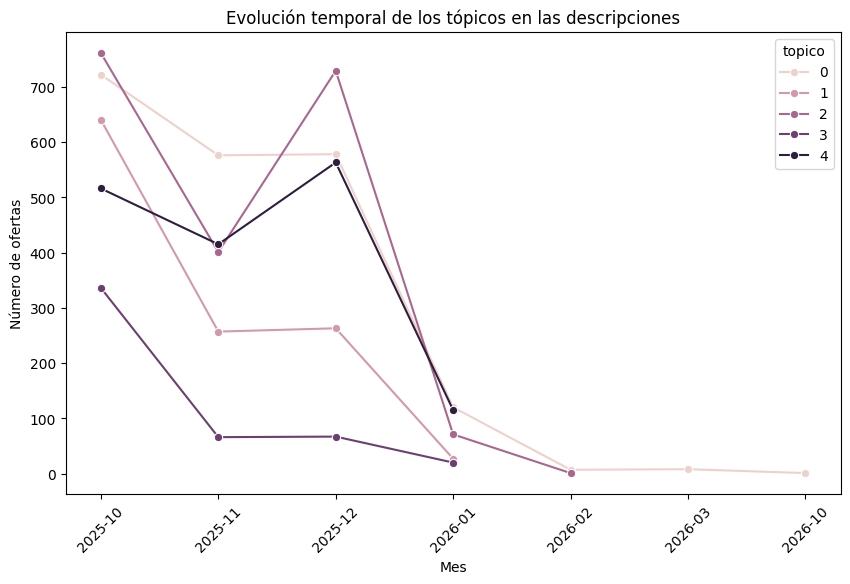

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns


# Por mes
df['mes'] = df['timestamp'].dt.to_period('M')

# Conteo
temporal_topics = df.groupby(['mes', 'topico']).size().reset_index(name='cuenta')

# Convert 'mes' to string for plotting
temporal_topics['mes'] = temporal_topics['mes'].astype(str)

# Gráfico
plt.figure(figsize=(10,6))
sns.lineplot(data=temporal_topics, x='mes', y='cuenta', hue='topico', marker='o')
plt.title('Evolución temporal de los tópicos en las descripciones')
plt.xlabel('Mes')
plt.ylabel('Número de ofertas')
plt.xticks(rotation=45)
plt.show()